In [1]:
# basics
import os
import time
import numpy as np
import pandas as pd

# scipy and sklearn
from scipy.stats import entropy
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import Image
from matplotlib.patches import Rectangle

# CMDGB
from CMGDB import PlotMorseSets, PlotMorseGraph

# local
from data_loaders import retrieve_predictions
from models import *
from utils import get_model_weights, convert_weight_dict_to_dataframe, compute_morse_graph, \
                  compute_morse_graph_with_gpflow_gp, compute_order_retraction

sns.set()
plt.style.use('ggplot')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
y_test_mnist = np.array(pd.read_csv("y_test_mnist.csv"))
y_test_iris = np.array(pd.read_csv("y_test_iris.csv"))

# Predictions

In [4]:
def plots_mnist(df_with_stats, y="pred_class", ylabel="Entropies of Predicted Labels", 
                fig_type="box", ylim=None):
    for plot_type in ["epoch", "batch", "layers"]:
        plot_df = df_with_stats.loc[df_with_stats["source"].str.contains(plot_type) |\
                                   df_with_stats["source"].str.contains("baseline")]

        plot_df[plot_type] = plot_df["source"].str.rsplit("_").str[-1]
        if plot_type == "epoch":
            plot_df[plot_type].replace({"baseline": 4}, inplace=True)
            xlabel = "Epochs"
        elif plot_type == "batch":
            plot_df[plot_type].replace({"baseline": 128}, inplace=True)
            xlabel = "Batch Size"
        elif plot_type == "layers":
            plot_df[plot_type].replace({"baseline": 1}, inplace=True)
            xlabel = "Layers"
        plot_df[plot_type] = plot_df[plot_type].astype(int)

        plt.figure(figsize=(10, 5))
        if fig_type == "box":
            ax = sns.boxplot(data=plot_df, x=plot_type, y=y)
        elif fig_type == "violin":
            ax = sns.violinplot(data=plot_df, x=plot_type, y=y)
        else:
            raise NotImplementedError("fig_type must be 'box' or 'violin'")
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title("Sweeping the {} of a baseline CNN on MNIST data".format(xlabel),
                     fontsize=20)
        ax.set_ylim(ylim)

        mbas = plot_df[[plot_type, "mean_balanced_accuracy"]].drop_duplicates().sort_values(by=plot_type)

        red = mpatches.Patch(color='indianred',
                             label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[0]))
        blue = mpatches.Patch(color='teal', 
                              label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[1]))
        purple = mpatches.Patch(color='mediumslateblue', 
                                label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[2]))
        black = mpatches.Patch(color='dimgray',
                               label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[3]))

        leg = ax.legend(handles=[red, blue, purple, black],
                        bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        leg.set_title("Mean Balanced Accuracy", prop = {'size':'large'})

In [5]:
def plots_iris(df_with_stats, y="pred_class", ylabel="Entropies of Predicted Labels", 
               fig_type="box", ylim=None):
    for plot_type in ["epoch", "batch", "layers", "nodes"]:
        plot_df = df_with_stats.loc[df_with_stats["source"].str.contains(plot_type) |\
                                   df_with_stats["source"].str.contains("baseline")]

        plot_df[plot_type] = plot_df["source"].str.rsplit("_").str[-1]
        if plot_type == "epoch":
            plot_df[plot_type].replace({"baseline": 150}, inplace=True)
            xlabel = "Epochs"
        elif plot_type == "batch":
            plot_df[plot_type].replace({"baseline": 5}, inplace=True)
            xlabel = "Batch Size"
        elif plot_type == "layers":
            plot_df[plot_type].replace({"baseline": 1}, inplace=True)
            xlabel = "Layers"
        elif plot_type == "nodes":
            plot_df = plot_df.loc[~plot_df["source"].str.contains("baseline")]
            xlabel = "Nodes"
        plot_df[plot_type] = plot_df[plot_type].astype(int)

        plt.figure(figsize=(10, 5))
        if fig_type == "box":
            ax = sns.boxplot(data=plot_df, x=plot_type, y=y)
        elif fig_type == "violin":
            ax = sns.violinplot(data=plot_df, x=plot_type, y=y)
        else:
            raise NotImplementedError("fig_type must be 'box' or 'violin'")
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title("Sweeping the {} of a baseline NN on Iris data".format(xlabel),
                     fontsize=20)
        ax.set_ylim(ylim)

        mbas = plot_df[[plot_type, "mean_balanced_accuracy"]].drop_duplicates().sort_values(by=plot_type)

        red = mpatches.Patch(color='indianred', 
                             label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[0]))
        blue = mpatches.Patch(color='teal', 
                              label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[1]))
        purple = mpatches.Patch(color='mediumslateblue',
                                label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[2]))
        black = mpatches.Patch(color='dimgray', 
                               label="{:.2f}".format(mbas["mean_balanced_accuracy"].values[3]))

        leg = ax.legend(handles=[red, blue, purple, black],
                        bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        leg.set_title("Mean Balanced Accuracy", prop = {'size':'large'})

In [6]:
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## MNIST

In [7]:
mnist_baseline_folder = ["mnist_baseline"]
mnist_epoch_folders = ["mnist_epoch_8", "mnist_epoch_12", "mnist_epoch_16"]
mnist_batch_folders = ["mnist_batch_32", "mnist_batch_64", "mnist_batch_256"]
mnist_layers_folders = ["mnist_layers_2", "mnist_layers_3", "mnist_layers_4"]
mnist_folder_names = mnist_baseline_folder + mnist_epoch_folders + mnist_batch_folders + mnist_layers_folders

In [8]:
mnist_df_list = []
for mfn in mnist_folder_names:
    dir_path = "./data/{}".format(mfn)
    preds_from_mfn = retrieve_predictions(y_test=y_test_mnist, outdir=dir_path)
    preds_from_mfn["source"] = mfn
    mnist_df_list.append(preds_from_mfn)
mnist_all_preds = pd.concat(mnist_df_list)

In [9]:
# add balanced accuracies
mnist_accuracies = mnist_all_preds.groupby(["source", "model"], as_index=False
                                          ).apply(lambda x: balanced_accuracy_score(x["pred_class"], 
                                                                                    x["real_class"]))

mnist_accuracies = mnist_accuracies.reset_index(drop=True).rename(columns={None: "mean_balanced_accuracy"})



# *****
# mnist_accuracies = mnist_accuracies.reset_index(drop=True).rename(columns={None: "balanced_accuracy"})

# for plot_type in ["epoch", "batch", "layers"]:
#     y="balanced_accuracy"
#     ylabel="Balanced Accuracy"
#     ylim=(-0.05, 1.05)
#     plot_df = mnist_accuracies.loc[mnist_accuracies["source"].str.contains(plot_type) |\
#                                mnist_accuracies["source"].str.contains("baseline")]

#     plot_df[plot_type] = plot_df["source"].str.rsplit("_").str[-1]
#     if plot_type == "epoch":
#         plot_df[plot_type].replace({"baseline": 4}, inplace=True)
#         xlabel = "Epochs"
#     elif plot_type == "batch":
#         plot_df[plot_type].replace({"baseline": 128}, inplace=True)
#         xlabel = "Batch Size"
#     elif plot_type == "layers":
#         plot_df[plot_type].replace({"baseline": 1}, inplace=True)
#         xlabel = "Layers"
#     plot_df[plot_type] = plot_df[plot_type].astype(int)


#     plt.figure(figsize=(10, 5))
#     ax = sns.violinplot(data=plot_df, x=plot_type, y=y)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title("Sweeping the {} of a baseline CNN on MNIST data".format(xlabel),
#                  fontsize=20)
#     ax.set_ylim(ylim)

# *****




avg_mnist_accuracies = mnist_accuracies.groupby("source", as_index=False).mean()
avg_mnist_accuracies["mean_balanced_accuracy"] = avg_mnist_accuracies["mean_balanced_accuracy"]

mnist_all_preds = pd.merge(mnist_all_preds, avg_mnist_accuracies, on="source", how="left")

In [10]:
# mnist_all_preds

In [11]:
mnist_entropies = mnist_all_preds.groupby(["source", "point"], 
                                          as_index=False).agg({"p0": np.mean, "p1": np.mean,
                                                               "mean_balanced_accuracy": np.mean})

mnist_entropies["entropy"] = mnist_entropies.apply(lambda x: entropy([x["p0"], x["p1"]]), axis=1)

mnist_stds = mnist_all_preds.groupby(["source", "point"], 
                                     as_index=False).agg({"pred_class": np.std,
                                                          "mean_balanced_accuracy": np.mean})

In [12]:
# plots_mnist(df_with_stats=mnist_entropies, fig_type="box", ylim=(-0.05, 1.05),
#              y="entropy", ylabel="Entropies of Predicted Probabilities")

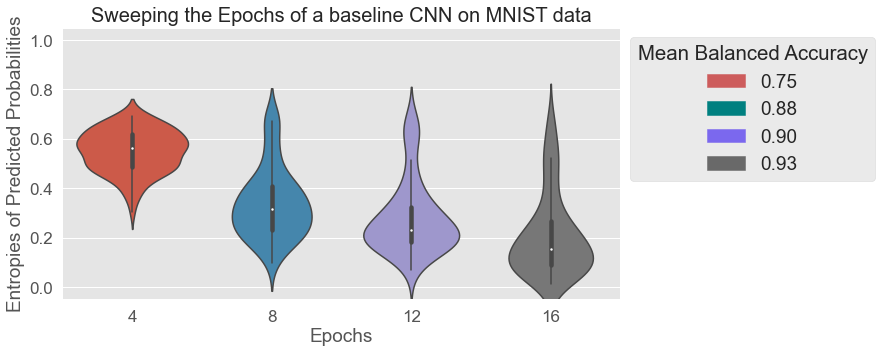

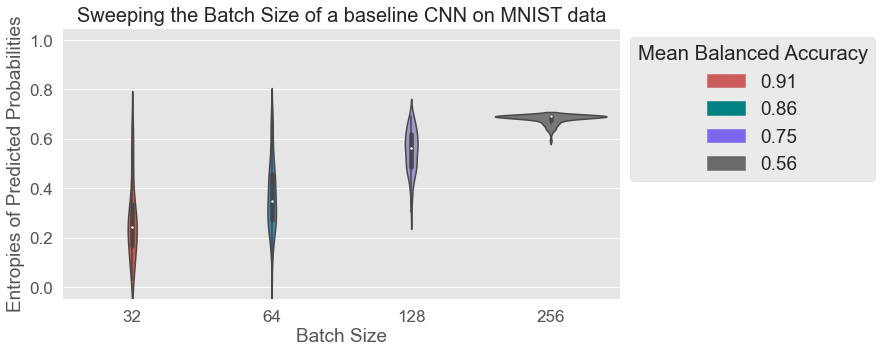

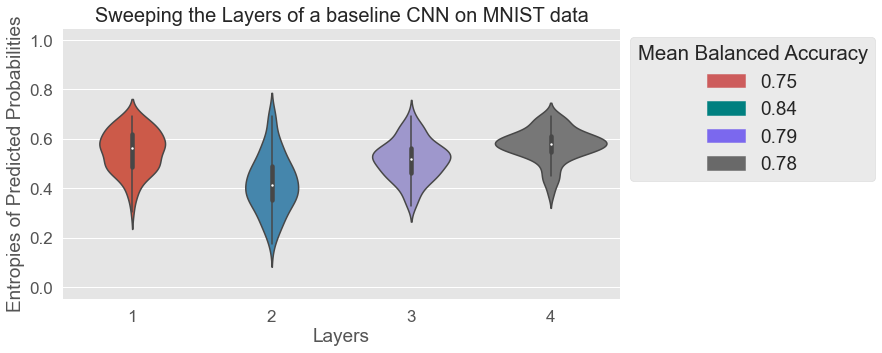

In [13]:
plots_mnist(df_with_stats=mnist_entropies, fig_type="violin", ylim=(-0.05, 1.05),
             y="entropy", ylabel="Entropies of Predicted Probabilities")

## IRIS

In [14]:
iris_baseline_folder = ["iris_baseline"]
iris_epoch_folders = ["iris_epoch_100", "iris_epoch_300", "iris_epoch_450"]
iris_batch_folders = ["iris_batch_10", "iris_batch_20", "iris_batch_40"]
iris_layers_folders = ["iris_layers_2", "iris_layers_3", "iris_layers_4"]
iris_nodes_folders = ["iris_nodes_3", "iris_nodes_4", "iris_nodes_5", "iris_nodes_6"]
iris_folder_names = iris_baseline_folder + iris_epoch_folders + iris_batch_folders + \
                    iris_layers_folders + iris_nodes_folders

In [15]:
iris_df_list = []
for mfn in iris_folder_names:
    dir_path = "./data/{}".format(mfn)
    preds_from_mfn = retrieve_predictions(y_test=y_test_iris, outdir=dir_path)
    preds_from_mfn["source"] = mfn
    iris_df_list.append(preds_from_mfn)
iris_all_preds = pd.concat(iris_df_list)

In [16]:
# add balanced accuracies
iris_accuracies = iris_all_preds.groupby(["source", "model"], as_index=False
                                        ).apply(lambda x: balanced_accuracy_score(x["pred_class"], 
                                                                                  x["real_class"]))
iris_accuracies = iris_accuracies.reset_index(drop=True).rename(columns={None: "mean_balanced_accuracy"})


# *****
# iris_accuracies = iris_accuracies.reset_index(drop=True).rename(columns={None: "balanced_accuracy"})

# for plot_type in ["epoch", "batch", "layers", "nodes"]:
#     y="balanced_accuracy"
#     ylabel="Balanced Accuracy"
#     ylim=(-0.05, 1.05)
#     plot_df = iris_accuracies.loc[iris_accuracies["source"].str.contains(plot_type) |\
#                                iris_accuracies["source"].str.contains("baseline")]

#     plot_df[plot_type] = plot_df["source"].str.rsplit("_").str[-1]
#     if plot_type == "epoch":
#         plot_df[plot_type].replace({"baseline": 150}, inplace=True)
#         xlabel = "Epochs"
#     elif plot_type == "batch":
#         plot_df[plot_type].replace({"baseline": 5}, inplace=True)
#         xlabel = "Batch Size"
#     elif plot_type == "layers":
#         plot_df[plot_type].replace({"baseline": 1}, inplace=True)
#         xlabel = "Layers"
#     elif plot_type == "nodes":
#         plot_df = plot_df.loc[~plot_df["source"].str.contains("baseline")]
#         xlabel = "Nodes"
#     plot_df[plot_type] = plot_df[plot_type].astype(int)


#     plt.figure(figsize=(10, 5))
#     ax = sns.violinplot(data=plot_df, x=plot_type, y=y)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title("Sweeping the {} of a baseline NN on Iris data".format(xlabel),
#                  fontsize=20)
#     ax.set_ylim(ylim)

# *****



avg_iris_accuracies = iris_accuracies.groupby("source", as_index=False).mean()

iris_all_preds = pd.merge(iris_all_preds, avg_iris_accuracies, on="source", how="left")

In [17]:
# iris_all_preds

In [18]:
iris_entropies = iris_all_preds.groupby(["source", "point"], 
                                          as_index=False).agg({"p0": np.mean, "p1": np.mean, "p2": np.mean,
                                                               "mean_balanced_accuracy": np.mean})

iris_entropies["entropy"] = iris_entropies.apply(lambda x: entropy([x["p0"], x["p1"], x["p2"]]), axis=1)

iris_stds = iris_all_preds.groupby(["source", "point"], 
                                     as_index=False).agg({"pred_class": np.std,
                                                          "mean_balanced_accuracy": np.mean})

In [19]:
# plots_iris(df_with_stats=iris_entropies, fig_type="box", ylim=(-0.05, 1.05),
#            y="entropy", ylabel="Entropies of Predicted Probabilities")

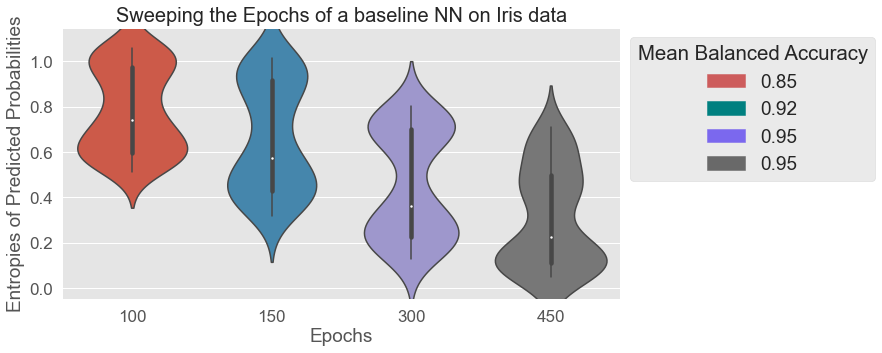

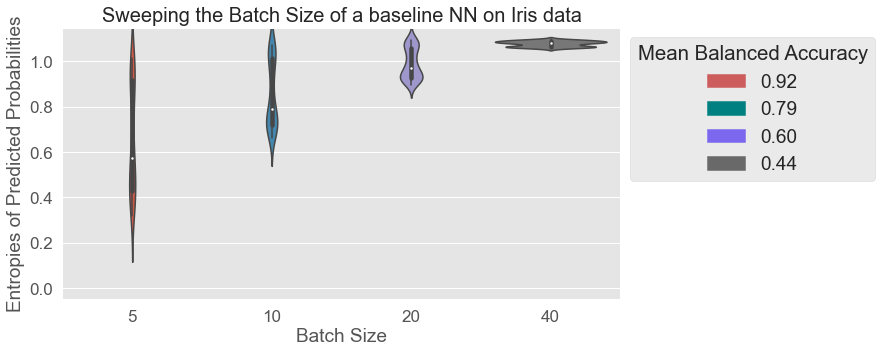

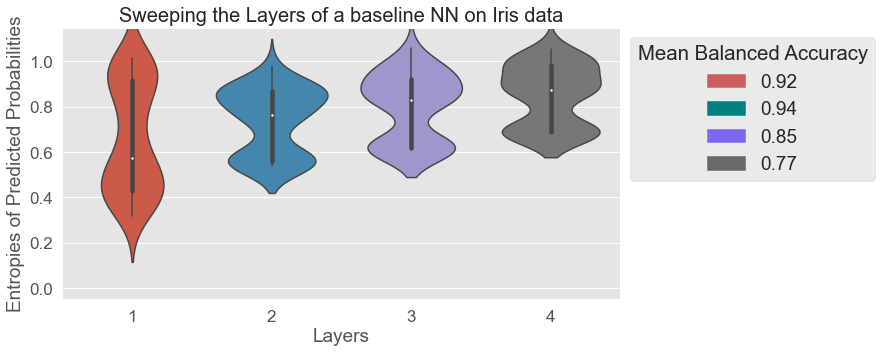

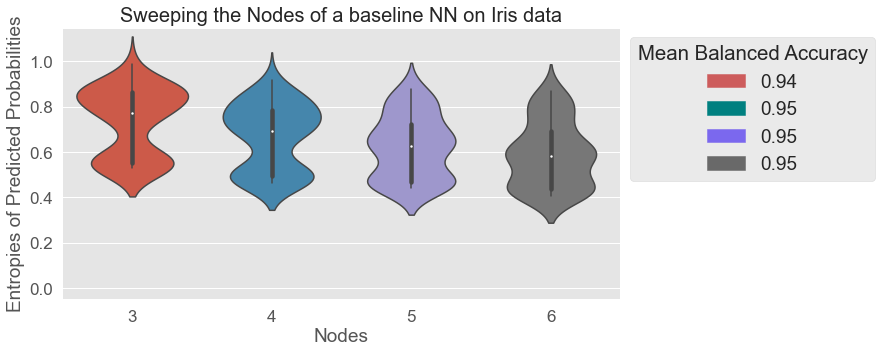

In [20]:
plots_iris(df_with_stats=iris_entropies, fig_type="violin", ylim=(-0.05, 1.15),
           y="entropy", ylabel="Entropies of Predicted Probabilities")

# Weights

## MNIST model weights

In [21]:
temp_list = []
for mfn in mnist_folder_names:
    weights = get_model_weights("./data/{}".format(mfn))
    weights = convert_weight_dict_to_dataframe(weights)
    weights = weights.loc[weights["epoch"] != "1"]
    weight_cols = [c for c in list(weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
    list_of_weight_stds = [np.std(weights[col]) for col in weight_cols]
    df = pd.DataFrame({"source": [mfn]*len(list_of_weight_stds), "std": list_of_weight_stds})
    temp_list.append(df)
mnist_weight_stds = pd.concat(temp_list)
mnist_weight_stds = pd.merge(mnist_weight_stds, avg_mnist_accuracies, on="source", how="left")

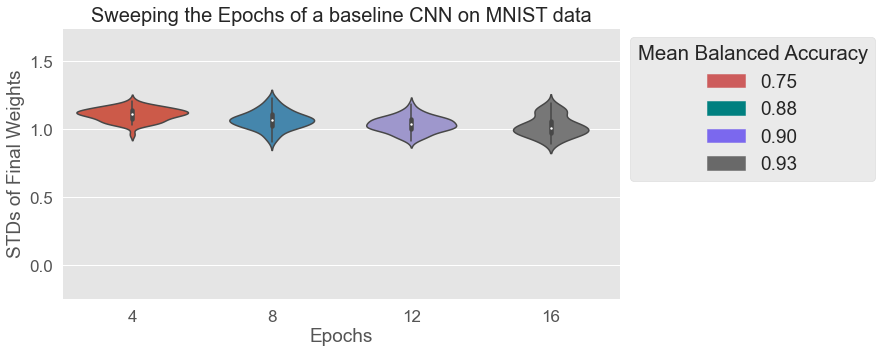

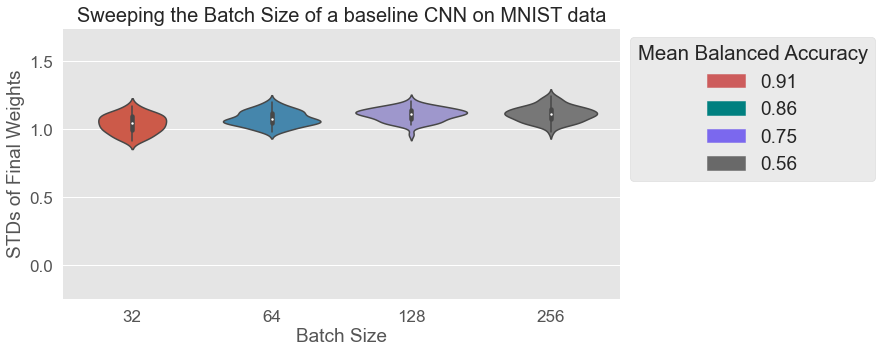

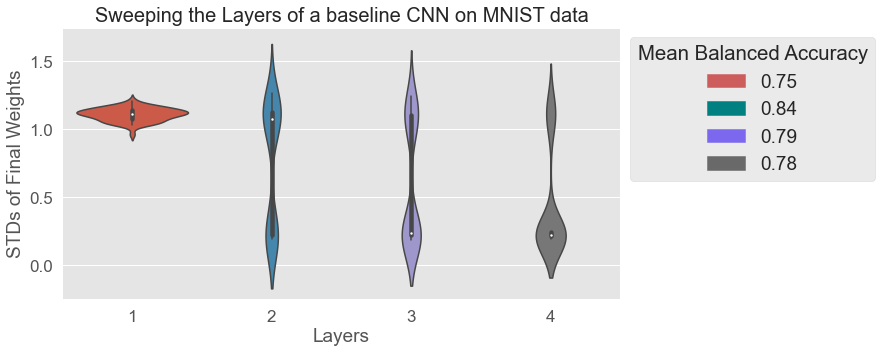

In [22]:
plots_mnist(df_with_stats=mnist_weight_stds, y="std", ylabel="STDs of Final Weights", fig_type="violin", 
            ylim=(-0.25, 1.75))

## Iris Model Weights

In [23]:
temp_list = []
for mfn in iris_folder_names:
    weights = get_model_weights("./data/{}".format(mfn))
    weights = convert_weight_dict_to_dataframe(weights)
    weights = weights.loc[weights["epoch"] != "1"]
    weight_cols = [c for c in list(weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
    list_of_weight_stds = [np.std(weights[col]) for col in weight_cols]
    df = pd.DataFrame({"source": [mfn]*len(list_of_weight_stds), "std": list_of_weight_stds})
    temp_list.append(df)
iris_weight_stds = pd.concat(temp_list)
iris_weight_stds = pd.merge(iris_weight_stds, avg_iris_accuracies, on="source", how="left")

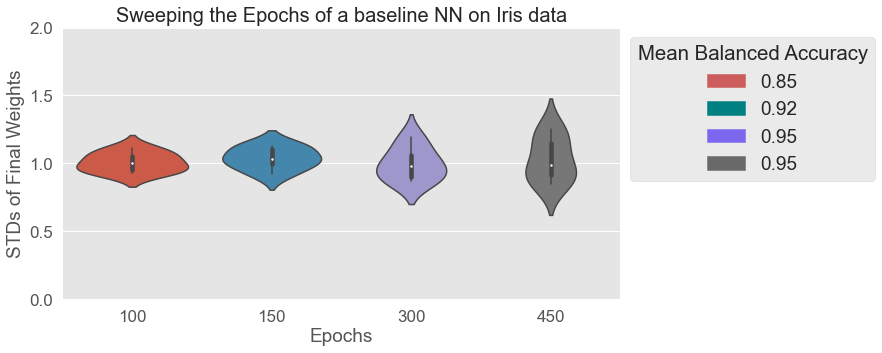

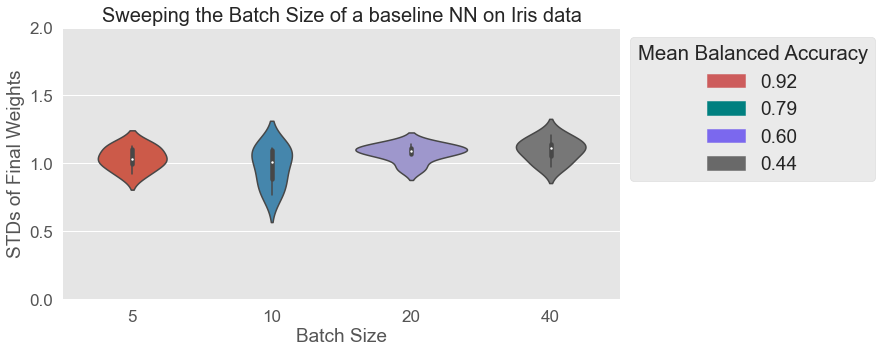

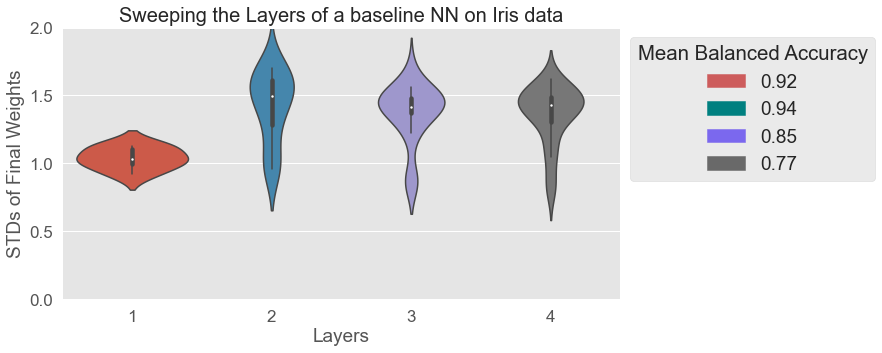

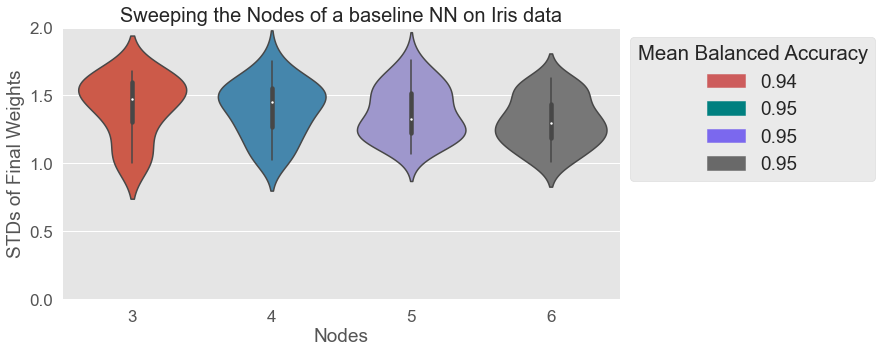

In [24]:
plots_iris(df_with_stats=iris_weight_stds, y="std", ylabel="STDs of Final Weights", fig_type="violin", ylim=(0,2))

# Morse Graphs

## MNIST Morse Graphs

[-0.26014438  0.783934  ]
[ 5.63678005e-53 -3.00398883e-53]


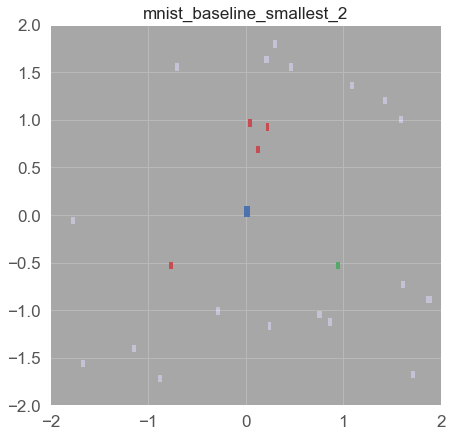

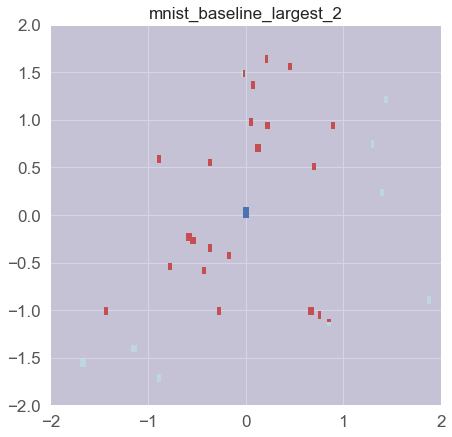

[ 5.41316455e-188 -2.37279920e-188]
[0. 0.]


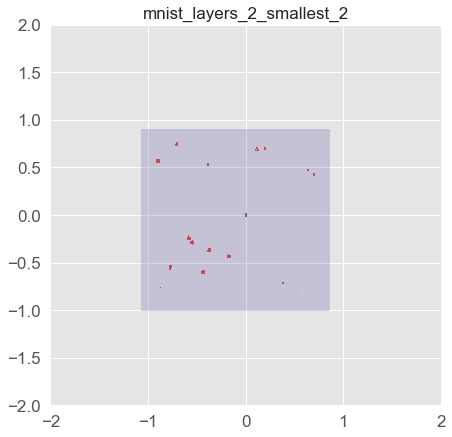

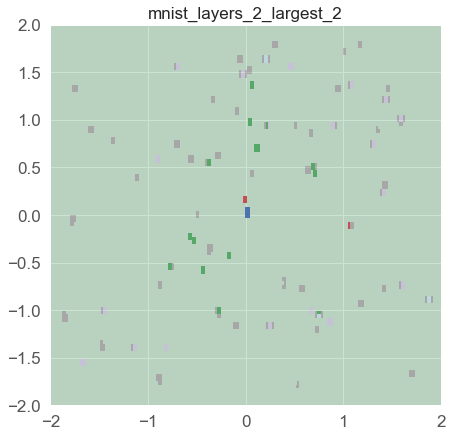

[-4.13490985e-18 -2.47002852e-18]
[0. 0.]


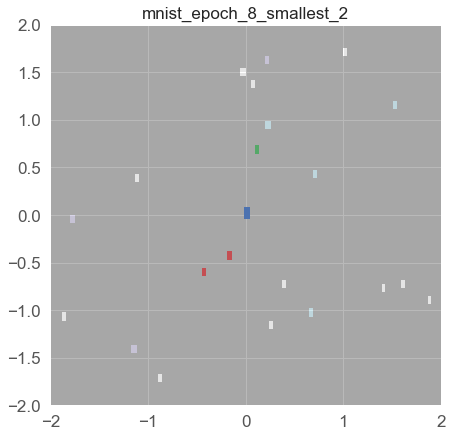

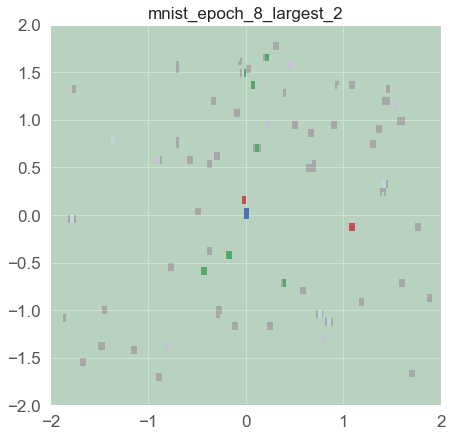

[8.50312925e-41 1.43205495e-40]
[ 3.39913366e-251 -4.00187747e-251]


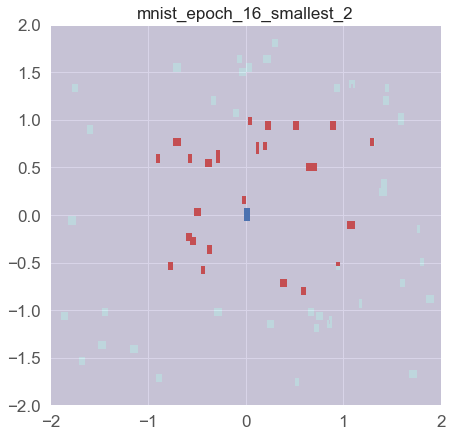

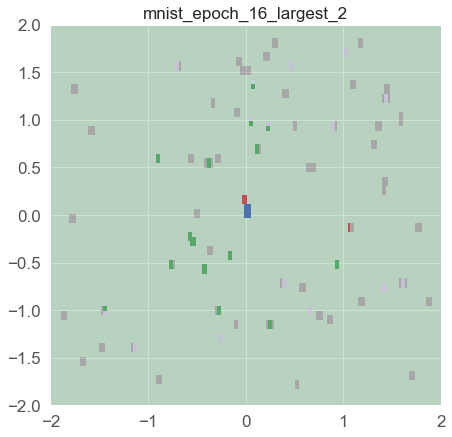

In [25]:
interesting_mnist = ["mnist_baseline", "mnist_layers_2", "mnist_epoch_8", "mnist_epoch_16"]

morse_graph_dict_mnist = {}
map_graph_dict_mnist = {}
for im in interesting_mnist:
    weights = get_model_weights("./data/{}".format(im))
    weights = convert_weight_dict_to_dataframe(weights)
    
    final_weights = weights.loc[weights["epoch"] != "1"]    
    weight_cols = [c for c in list(final_weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
    std_df = pd.DataFrame(columns=["weight_name", "std"],
                          data=list(zip(weight_cols, [np.std(final_weights[col]) for col in weight_cols])))
    std_df = std_df.sort_values(by="std")
    smallest_2 = list(std_df["weight_name"])[:2]
    largest_2 = list(std_df["weight_name"])[-2:]

    morseg_small, mapg_small = compute_morse_graph(weights[['epoch'] + smallest_2], phase_subdiv=15)
    morseg_large, mapg_large = compute_morse_graph(weights[['epoch'] + largest_2], phase_subdiv=15)
    
    morse_graph_dict_mnist["{}_smallest_2".format(im)] = morseg_small
    morse_graph_dict_mnist["{}_largest_2".format(im)] = morseg_large
    
    map_graph_dict_mnist["{}_smallest_2".format(im)] = mapg_small
    map_graph_dict_mnist["{}_largest_2".format(im)] = mapg_large
    
    compute_order_retraction(morseg_small, mapg_small, title="{}_smallest_2".format(im))
    compute_order_retraction(morseg_large, mapg_large, title="{}_largest_2".format(im))

    plt.show()

mnist_baseline_smallest_2


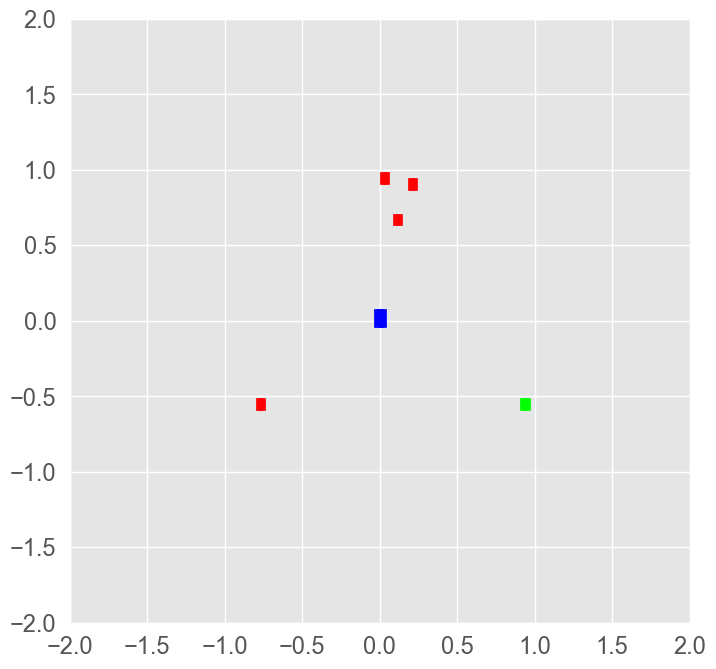

mnist_baseline_largest_2


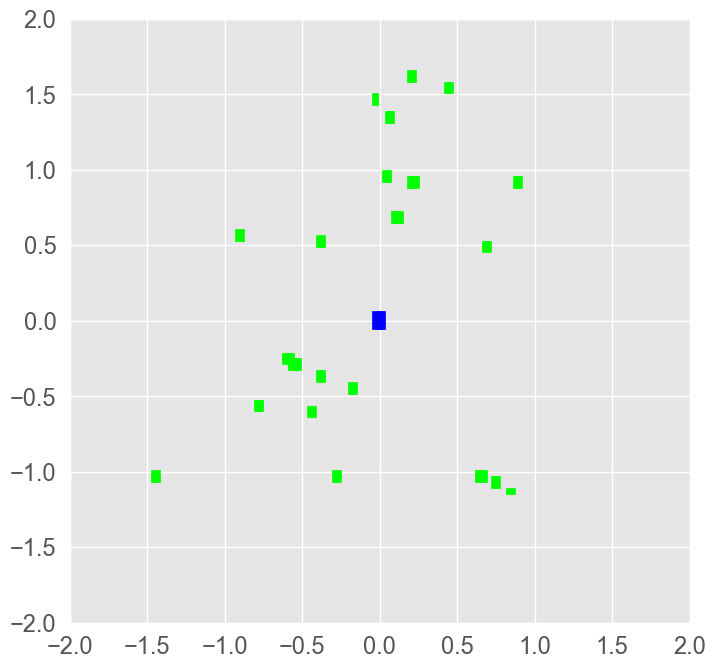

mnist_layers_2_smallest_2


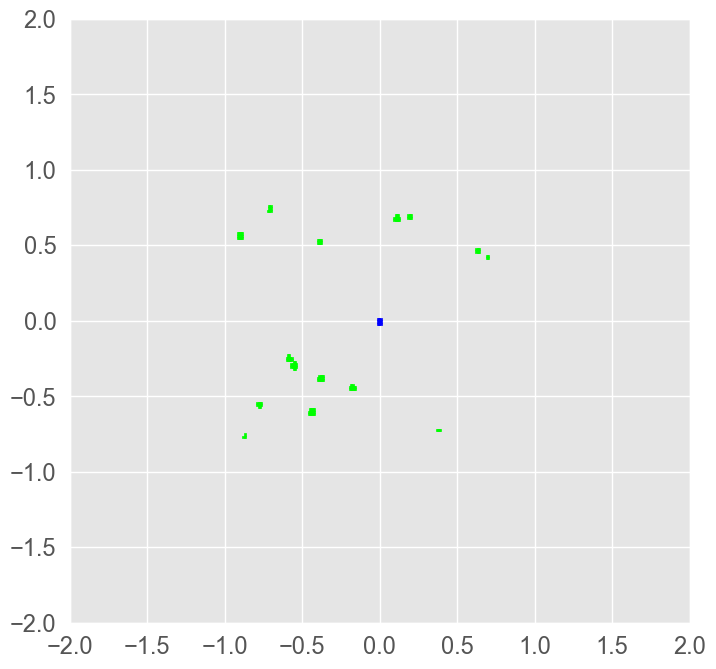

mnist_layers_2_largest_2


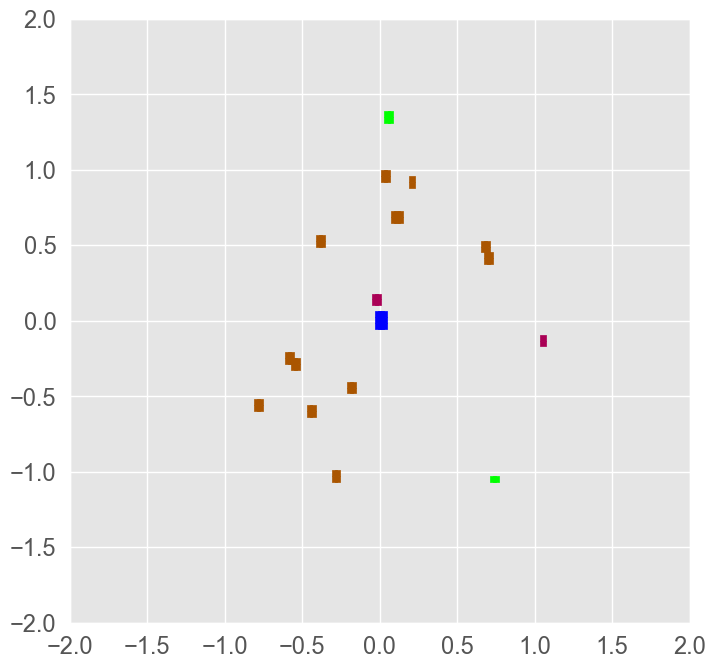

mnist_epoch_8_smallest_2


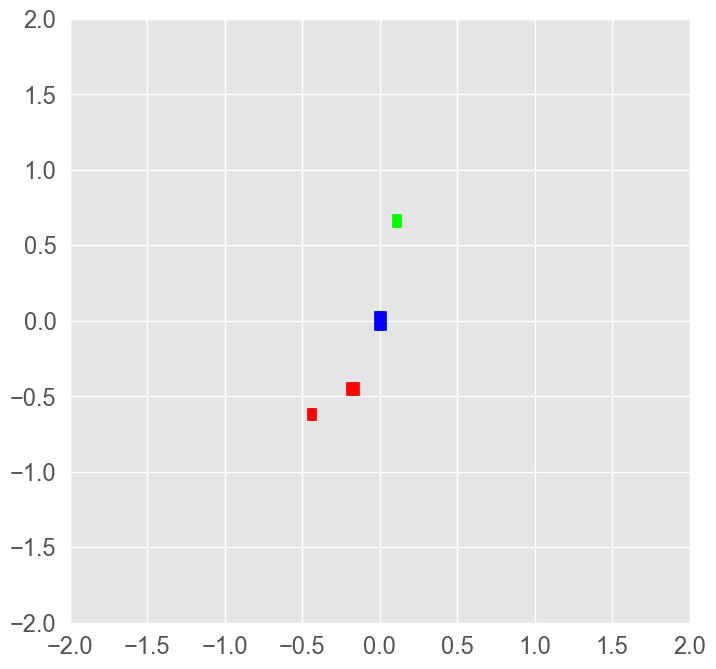

mnist_epoch_8_largest_2


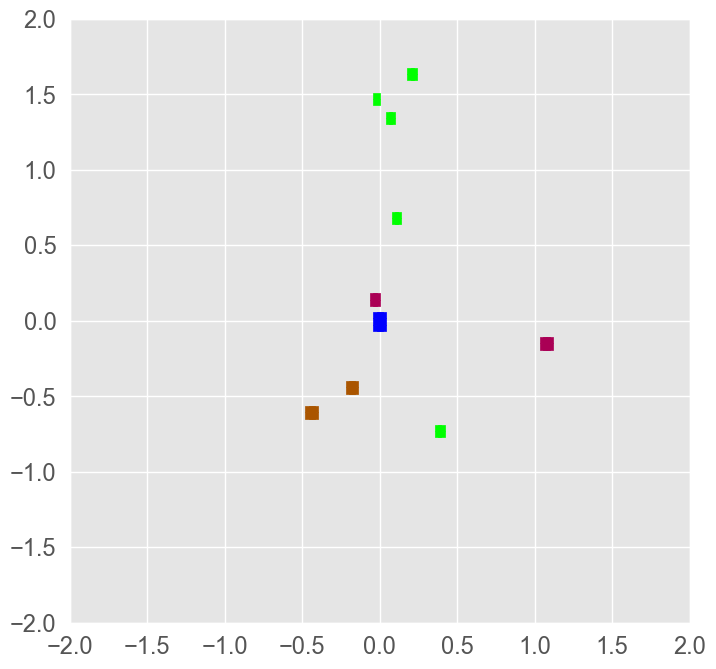

mnist_epoch_16_smallest_2


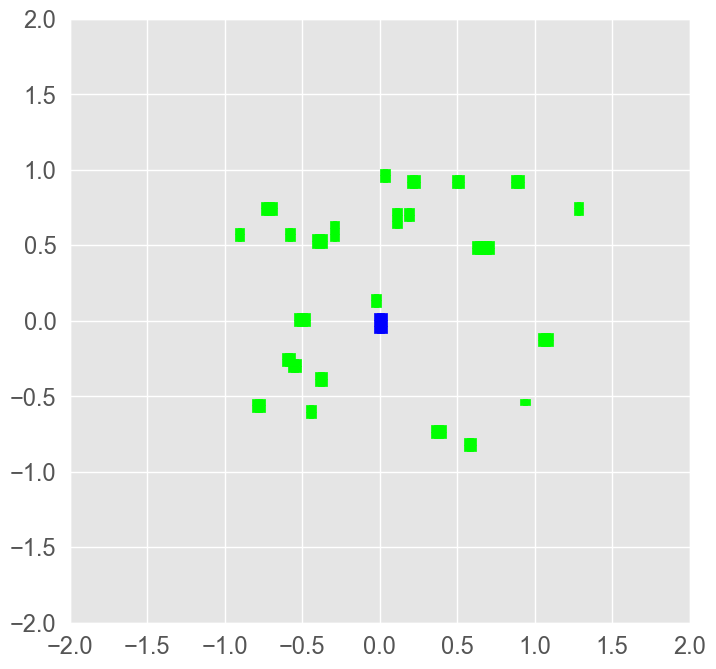

mnist_epoch_16_largest_2


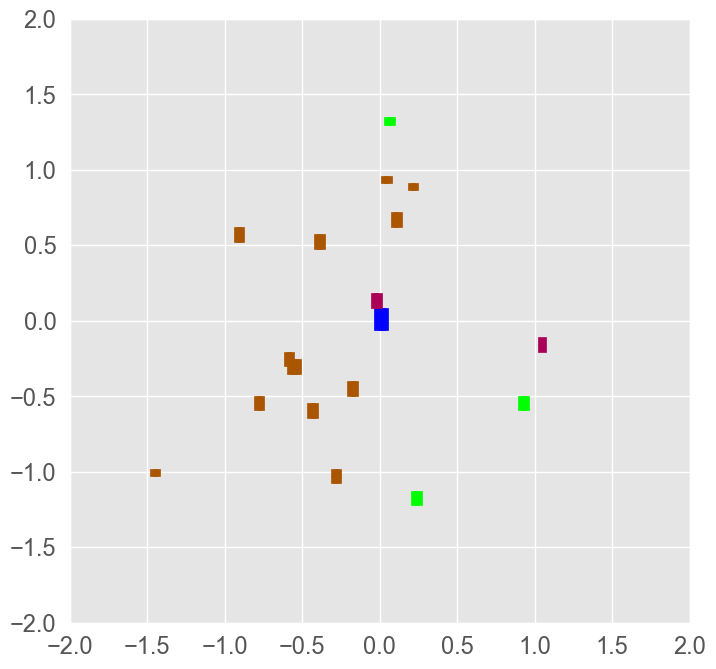

In [26]:
# plot distribution of two weights that you are using to see if they are actually ending up where the plots below show


for key, value in morse_graph_dict_mnist.items():
    print(key)
    PlotMorseSets(value, xlim=[-2, 2], ylim=[-2, 2])

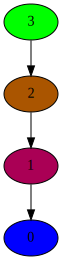

In [27]:
PlotMorseGraph(morse_graph_dict_mnist["mnist_epoch_16_largest_2"])

## Iris Morse Graphs

[-0.00027109  0.00012246]
[-1.22694802e-48  7.51693882e-49]


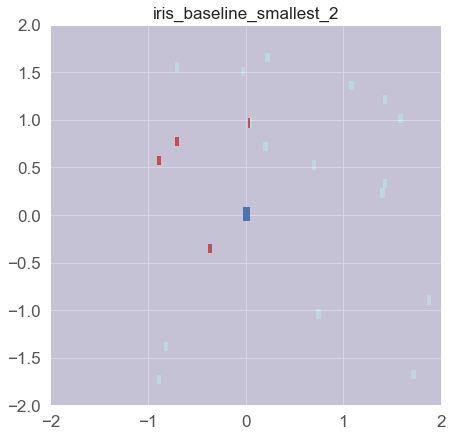

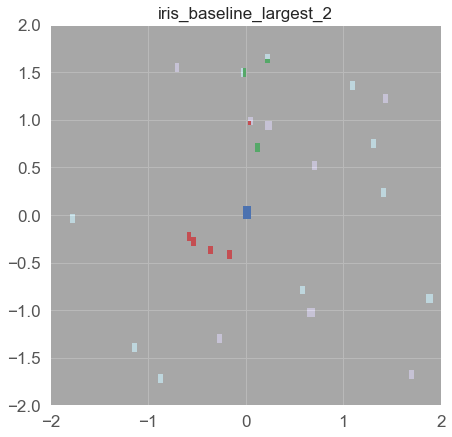

[-9.06192429e-124  1.18104968e-123]
[-5.87904354e-49  1.31590109e-47]


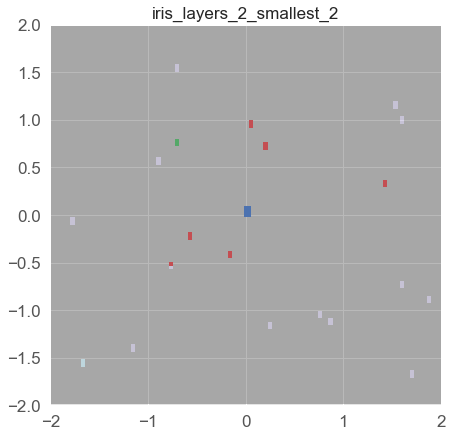

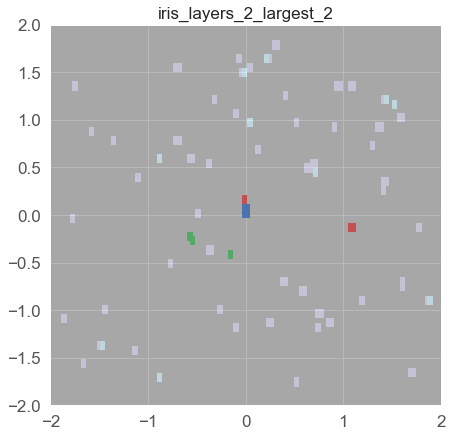

[-1.08772932e-205  5.36531876e-206]
[7.96500219e-83 4.05503641e-81]


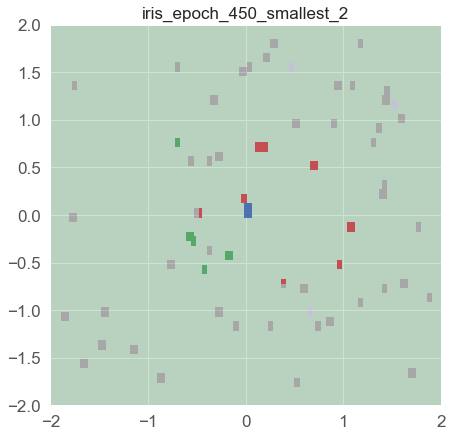

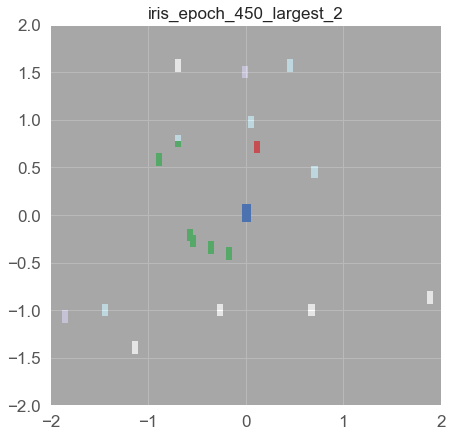

In [28]:
interesting_iris = ["iris_baseline", "iris_layers_2", "iris_epoch_450"]

morse_graph_dict_iris = {}
map_graph_dict_iris = {}
for ii in interesting_iris:
    weights = get_model_weights("./data/{}".format(ii))
    weights = convert_weight_dict_to_dataframe(weights)
    
    final_weights = weights.loc[weights["epoch"] != "1"]  
    weight_cols = [c for c in list(final_weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
    std_df = pd.DataFrame(columns=["weight_name", "std"],
                          data=list(zip(weight_cols, [np.std(final_weights[col]) for col in weight_cols])))
    std_df = std_df.sort_values(by="std")
    smallest_2 = list(std_df["weight_name"])[:2]
    largest_2 = list(std_df["weight_name"])[-2:]

    morseg_small, mapg_small = compute_morse_graph(weights[['epoch'] + smallest_2], phase_subdiv=15)
    morseg_large, mapg_large = compute_morse_graph(weights[['epoch'] + largest_2], phase_subdiv=15)
    
    morse_graph_dict_iris["{}_smallest_2".format(ii)] = morseg_small
    morse_graph_dict_iris["{}_largest_2".format(ii)] = morseg_large
    
    map_graph_dict_iris["{}_smallest_2".format(ii)] = mapg_small
    map_graph_dict_iris["{}_largest_2".format(ii)] = mapg_large
    
    compute_order_retraction(morseg_small, mapg_small, title="{}_smallest_2".format(ii))
    compute_order_retraction(morseg_large, mapg_large, title="{}_largest_2".format(ii))    
    
    plt.show()

iris_baseline_smallest_2


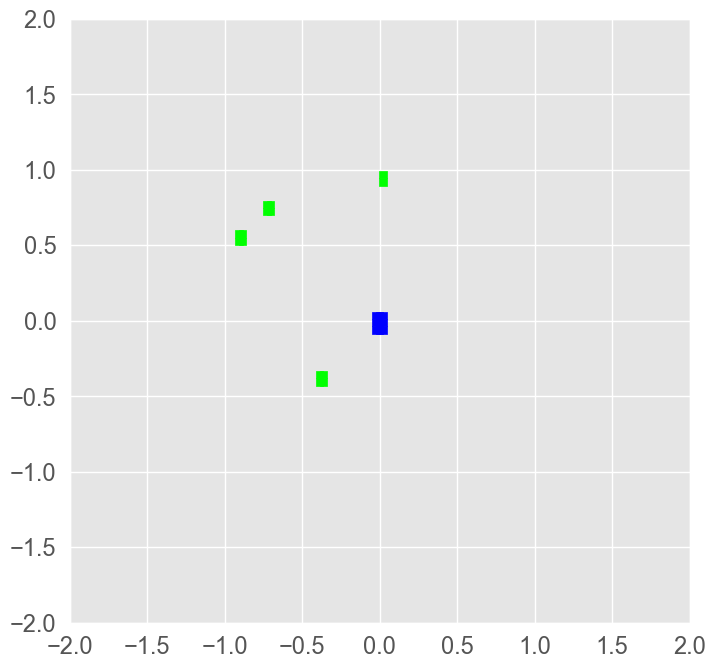

iris_baseline_largest_2


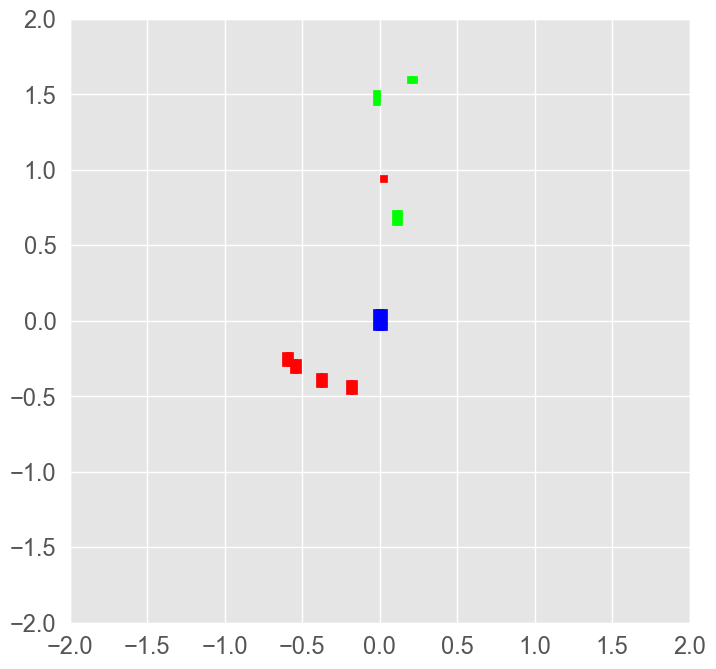

iris_layers_2_smallest_2


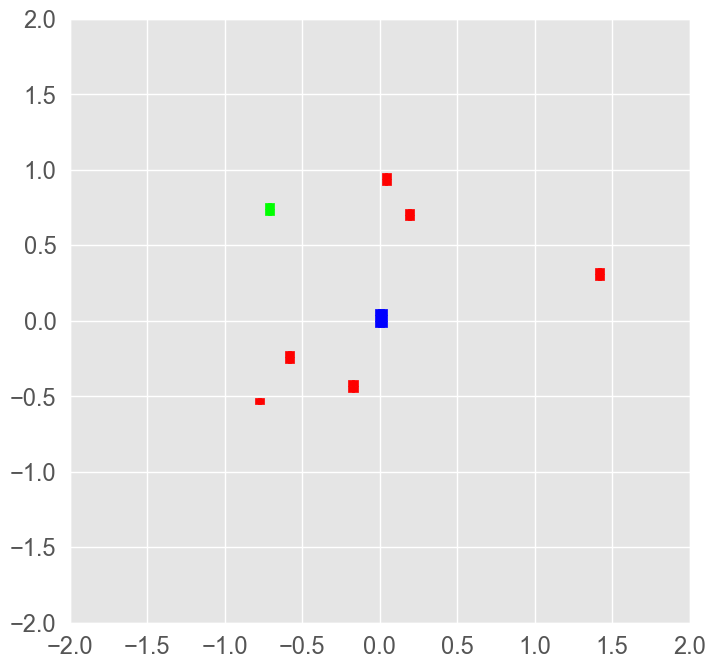

iris_layers_2_largest_2


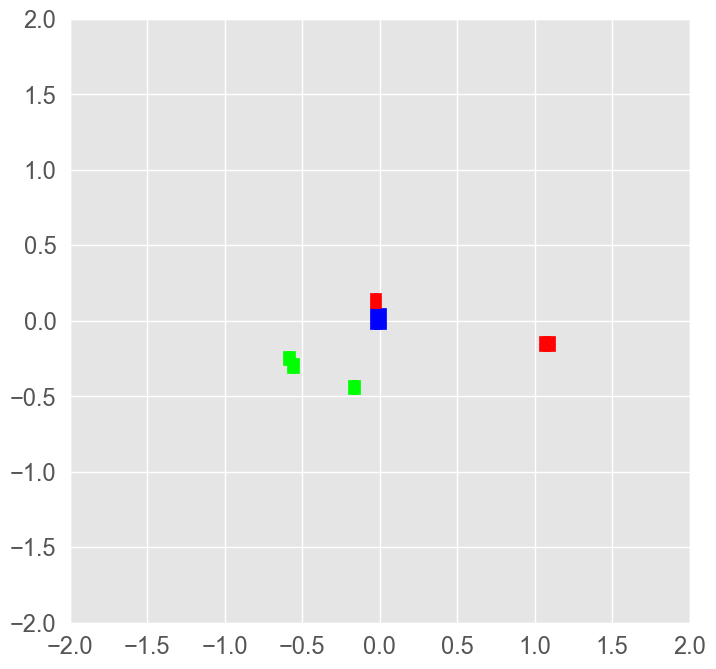

iris_epoch_450_smallest_2


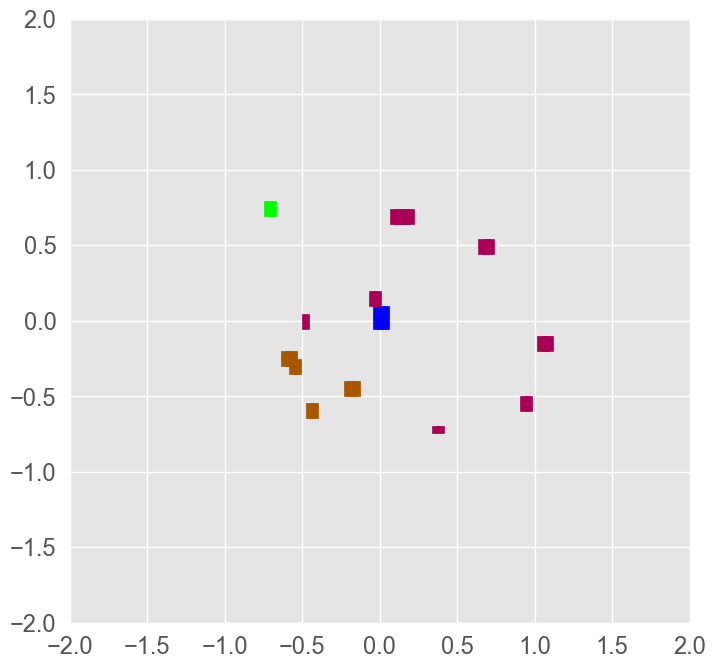

iris_epoch_450_largest_2


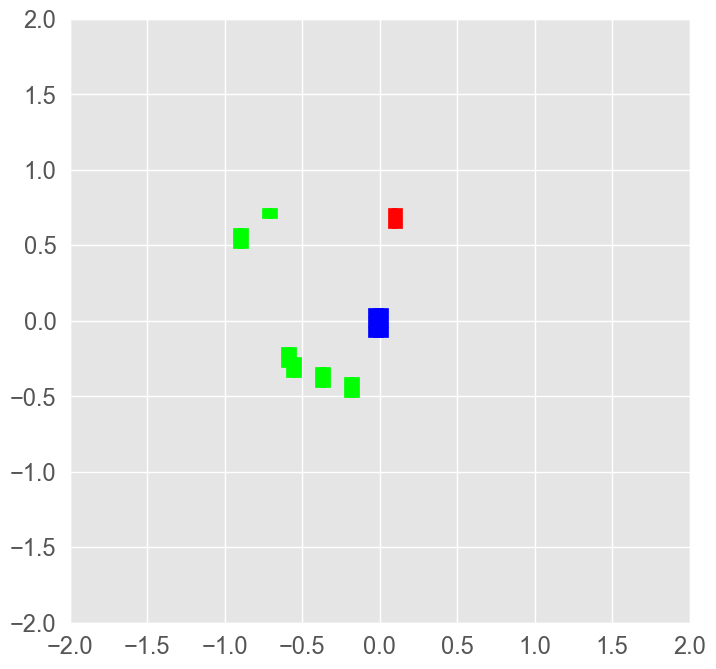

In [29]:
for key, value in morse_graph_dict_iris.items():
    print(key)
    PlotMorseSets(value, xlim=[-2, 2], ylim=[-2, 2])

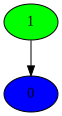

In [30]:
PlotMorseGraph(morse_graph_dict_iris["iris_baseline_smallest_2"])

## Supplementary histograms of model weights

In [31]:
# for im in interesting_mnist:
#     weights = get_model_weights("./data/{}".format(im))
#     weights = convert_weight_dict_to_dataframe(weights)
    
#     final_weights = weights.loc[weights["epoch"] != "1"]    
#     weight_cols = [c for c in list(final_weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
#     std_df = pd.DataFrame(columns=["weight_name", "std"],
#                           data=list(zip(weight_cols, [np.std(final_weights[col]) for col in weight_cols])))
#     std_df = std_df.sort_values(by="std")
#     smallest_2 = list(std_df["weight_name"])[:2]
#     largest_2 = list(std_df["weight_name"])[-2:]
    
#     for w in smallest_2 + largest_2:
#         std = np.std(final_weights[w])
#         figure = plt.figure()
#         ax = sns.distplot(final_weights[w], norm_hist=False, kde=False)
#         ax.set_title("{} (Std = {:.2f})".format(w, std))

In [32]:
# for ii in interesting_iris:
#     weights = get_model_weights("./data/{}".format(ii))
#     weights = convert_weight_dict_to_dataframe(weights)
    
#     final_weights = weights.loc[weights["epoch"] != "1"]  
#     weight_cols = [c for c in list(final_weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
#     std_df = pd.DataFrame(columns=["weight_name", "std"],
#                           data=list(zip(weight_cols, [np.std(final_weights[col]) for col in weight_cols])))
#     std_df = std_df.sort_values(by="std")
#     smallest_2 = list(std_df["weight_name"])[:2]
#     largest_2 = list(std_df["weight_name"])[-2:]

#     for w in smallest_2 + largest_2:
#         std = np.std(final_weights[w])
#         figure = plt.figure()
#         ax = sns.distplot(final_weights[w], norm_hist=False, kde=False)
#         ax.set_title("{} (Std = {:.2f})".format(w, std))